# 27. YouTube 영상 요약하기 

## 프로젝트 개요

이 노트북은 YouTube 영상을 자동으로 다운로드하고, OpenAI Whisper를 사용하여 텍스트로 변환한 후, 내용을 요약하여 Notion 데이터베이스에 자동으로 업로드하는 고급 시스템을 구축합니다. 

### 주요 기능
1. **YouTube 영상 처리**: URL을 통한 자동 다운로드 및 텍스트 변환
2. **자동 요약**: AI를 활용한 마크다운 형식의 구조화된 아웃라인 생성
3. **MCP 연동**: Model Context Protocol을 사용한 Notion API 고급 활용
4. **ReAct 에이전트**: 복잡한 작업을 수행하는 지능형 에이전트 구현

## 1. 환경 설정

In [1]:
# 환경 변수 로드 - OpenAI API 키와 Notion API 키를 .env 파일에서 불러옵니다
from dotenv import load_dotenv

# .env 파일에서 환경 변수 로드 (OpenAI API 키, Notion API 키 등)
load_dotenv()

True

## 2. 워크플로우 상태 정의

LangGraph에서 사용할 고급 상태 구조를 정의합니다. 이 상태는 YouTube URL부터 Notion 페이지 생성까지의 전체 워크플로우를 관리합니다.


In [2]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph

# 워크플로우에서 사용할 고급 상태 구조 정의
class AgentState(TypedDict):
    url: str           # YouTube 영상 URL
    transcript: str    # Whisper로 추출한 텍스트
    outline: str       # 생성된 마크다운 아웃라인
    title: str         # 영상/문서 제목
    database_id: str   # Notion 데이터베이스 ID
    page_id: str       # 생성된 Notion 페이지 ID
    save_dir: str      # 다운로드한 영상 파일 저장 경로
    
# 상태 그래프 빌더 초기화
graph_builder = StateGraph(AgentState)

## 3. AI 모델 및 로더 초기화

YouTube 영상 처리를 위한 다양한 모델과 로더를 초기화합니다.


In [3]:
from langchain_openai import ChatOpenAI
from langchain_community.document_loaders.parsers.audio import OpenAIWhisperParser
from langchain_community.document_loaders.blob_loaders.youtube_audio import (
    YoutubeAudioLoader,  # YouTube 영상 오디오 다운로더
)
from langchain_community.document_loaders.generic import GenericLoader  # 범용 로더

# ChatGPT 모델 초기화 - 텍스트 요약과 아웃라인 생성에 사용
llm = ChatOpenAI(model="gpt-4o", temperature=0)  # 더 높은 품질의 결과를 위해 gpt-4o 사용


## 4. 워크플로우 노드 함수 정의

### 4.1 YouTube 트랜스크립트 추출 함수

YouTube URL에서 영상을 다운로드하고 OpenAI Whisper를 사용하여 음성을 텍스트로 변환하는 함수입니다.


In [4]:
from langchain_core.documents.base import Blob
from langchain_community.document_loaders.parsers.audio import OpenAIWhisperParser

def extract_transcript(state: AgentState) -> AgentState:
    """
    YouTube URL에서 영상을 다운로드하고 음성을 텍스트로 변환하는 함수
    """
    # 상태에서 YouTube URL과 저장 경로 가져오기
    url = state["url"]
    save_dir = state["save_dir"]
    
    # YouTube 오디오 다운로더와 Whisper 파서를 결합한 로더 생성
    loader = GenericLoader(
        YoutubeAudioLoader([url], save_dir),  # YouTube 영상 다운로드
        OpenAIWhisperParser()                 # Whisper를 사용한 음성-텍스트 변환
    )
    
    # 변환된 텍스트들을 하나의 문자열로 결합
    transcript = ""
    documents = loader.load()
    for doc in documents:
        transcript += doc.page_content
    
    # 결과를 상태로 반환
    return {"transcript": transcript}

### 4.2 마크다운 아웃라인 생성 함수

추출된 텍스트를 바탕으로 구조화된 마크다운 형식의 한국어 아웃라인을 생성하는 함수입니다.


In [5]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

# 아웃라인 생성용 모델 (고품질 결과를 위해 gpt-4o 사용)
llm = ChatOpenAI(model="gpt-4o", temperature=0)

def generate_outline(state: AgentState) -> AgentState:
    """
    추출된 텍스트를 바탕으로 구조화된 마크다운 형식의 한국어 아웃라인을 생성하는 함수
    """
    # 상태에서 트랜스크립트 가져오기
    transcript = state["transcript"]
    
    # 마크다운 형식의 아웃라인 생성을 위한 프롬프트 템플릿 설정
    outline_prompt = ChatPromptTemplate.from_messages([
        ("system", """You are a helpful assistant that generates an outline for a transcript. 
Your outline must be in the markdown format using necessary headings and subheadings.
You can also use bullet points and numbered lists where you think necessary.
Make sure to use Korean when you generate the outline."""),
        ("user", "Generate an outline for the following transcript: {transcript}"),
    ])
    
    # 체인 구성: 프롬프트 -> LLM -> 문자열 파서
    outline_chain = outline_prompt | llm | StrOutputParser()
    
    # 마크다운 아웃라인 생성
    outline = outline_chain.invoke({"transcript": transcript})
    
    # 결과를 상태로 반환
    return {"outline": outline}

## 5. MCP (Model Context Protocol) 클라이언트 설정

### 5.1 MCP 클라이언트 초기화

MCP를 사용하여 Notion API와의 고급 상호작용을 위한 클라이언트를 설정합니다. 이는 26번 노트북의 직접적인 API 호출보다 더 유연하고 강력한 방법입니다.


In [6]:
import os
from langchain_mcp_adapters.client import MultiServerMCPClient

# 환경 변수에서 Notion API 키 가져오기
notion_api_key = os.getenv("NOTION_API_KEY")

# MCP 클라이언트 설정 - Notion API와의 고급 상호작용을 위한 프로토콜
mcp_client = MultiServerMCPClient({
  "notionApi": {
      "command": "npx",  # Node.js 패키지 실행 명령
      "args": ["-y", "@notionhq/notion-mcp-server"],  # Notion MCP 서버 패키지 실행
      "env": {
        # OpenAPI MCP 헤더 설정 (인증 정보 포함)
        "OPENAPI_MCP_HEADERS": f"{{\"Authorization\": \"Bearer {notion_api_key}\", \"Notion-Version\": \"2022-06-28\" }}"
      },
      "transport": "stdio"  # 표준 입출력을 통한 통신
    }  
})


### 5.2 도구 목록 가져오기

MCP 클라이언트에서 사용 가능한 도구들을 가져옵니다. 이 도구들은 Notion API와의 상호작용에 사용됩니다.


In [7]:
# MCP 클라이언트에서 사용 가능한 도구 목록 가져오기
# 이 도구들은 Notion API와의 상호작용에 사용됩니다
tool_list = await mcp_client.get_tools()

### 5.3 ReAct 에이전트 생성

ReAct (Reasoning and Acting) 에이전트를 생성합니다. 이 에이전트는 복잡한 작업을 수행하기 위해 추론과 행동을 반복합니다.


In [8]:
from langgraph.prebuilt import create_react_agent

# ReAct 에이전트 생성 - 복잡한 작업을 위한 추론과 행동을 반복하는 에이전트
agent = create_react_agent(
    model=llm,       # 사용할 언어 모델
    tools=tool_list, # MCP에서 가져온 도구 목록
    prompt="Use the tools provided to you to answer the user's question"  # 에이전트의 기본 프롬프트
)

### 5.4 스트림 처리 함수

에이전트 실행 중 생성되는 스트림을 처리하는 유틸리티 함수입니다. 실시간으로 에이전트의 행동을 추적할 수 있습니다.


In [9]:
async def process_stream(stream_generator):
    """
    에이전트 실행 중 생성되는 스트림을 처리하는 함수
    실시간으로 에이전트의 행동과 도구 사용을 추적합니다
    """
    results = []
    try:
        # 스트림에서 각 청크를 비동기적으로 처리
        async for chunk in stream_generator:
            # 청크에서 첫 번째 키 가져오기
            key = list(chunk.keys())[0]
            
            if key == 'agent':
                # Agent 메시지의 내용을 가져옴. 메세지가 비어있는 경우 어떤 도구를 어떻게 호출할지 정보를 가져옴
                content = chunk['agent']['messages'][0].content if chunk['agent']['messages'][0].content != '' else chunk['agent']['messages'][0].additional_kwargs
                print(f"'agent': '{content}'")
            
            elif key == 'tools':
                # 도구 메시지의 내용을 가져옴
                for tool_msg in chunk['tools']['messages']:
                    print(f"'tools': '{tool_msg.content}'")
            
            # 결과에 청크 추가
            results.append(chunk)
        return results
    except Exception as e:
        print(f"Error processing stream: {e}")
        return results

## 6. Notion 페이지 생성 및 업로드 함수

### 6.1 Notion 페이지 생성 함수

Notion 데이터베이스에 새로운 페이지를 생성하는 함수입니다. 이 함수는 직접적인 API 호출을 사용합니다.


In [10]:
import requests
import os

def create_notion_page(state: AgentState) -> AgentState:
    """
    Notion 데이터베이스에 새로운 페이지를 생성하는 함수
    직접적인 API 호출을 사용하여 제목만 설정된 빈 페이지를 생성합니다
    """
    # 상태에서 필요한 정보 가져오기
    database_id = state['database_id']  # Notion 데이터베이스 ID
    title = state['title']              # 페이지 제목
    
    # 환경 변수에서 Notion API 키 가져오기
    notion_api_key = os.getenv("NOTION_API_KEY")
    
    # Notion API 요청 헤더 설정
    headers = {
        'Authorization': f'Bearer {notion_api_key}',
        'Content-Type': 'application/json',
        'Notion-Version': '2022-06-28'  # Notion API 버전 지정
    }
    
    # 새 페이지 생성을 위한 데이터 구성
    data = {
        'parent': {'database_id': database_id},  # 부모 데이터베이스 지정
        'properties': {
            'Title': {'title': [{'text': {'content': title}}]},  # 페이지 제목만 설정
        },
    }
    
    # Notion API에 페이지 생성 요청
    response = requests.post(
        'https://api.notion.com/v1/pages',
        headers=headers,
        json=data
    )
    
    # 응답 결과 출력
    print(response.json())
    
    # 생성된 페이지 ID를 상태로 반환
    return {'page_id': response.json()['id']}

### 6.2 Notion 콘텐츠 업로드 함수

생성된 페이지에 마크다운 형식의 아웃라인을 구조화된 블록으로 추가하는 함수입니다. ReAct 에이전트와 MCP를 사용하여 복잡한 작업을 수행합니다.


In [11]:
from langchain_core.messages import HumanMessage
from langchain_core.prompts import PromptTemplate

async def upload_to_notion(state: AgentState) -> AgentState:
    """
    생성된 Notion 페이지에 마크다운 형식의 아웃라인을 구조화된 블록으로 추가하는 함수
    ReAct 에이전트와 MCP를 사용하여 복잡한 작업을 수행합니다
    """
    # 상태에서 필요한 정보 가져오기
    page_id = state['page_id']  # 이전 단계에서 생성된 페이지 ID
    outline = state['outline']  # 생성된 마크다운 아웃라인
    
    # 에이전트에게 전달할 메시지 프롬프트 템플릿 생성
    human_message_prompt = PromptTemplate.from_template("""Add block to the page of which id is {page_id}
and add the outline as children blocks to the page. 
Make sure to follow the format of the outline which is in markdown format
When you use headings, make sure to follow the format below:
{{
  //...other keys excluded
  "type": "heading_1", # heading_1, heading_2, heading_3
  //...other keys excluded
  "heading_1": {{
    "rich_text": [{{
      "type": "text",
      "text": {{
        "content": "Lacinato kale",
        "link": null
      }}
    }}],
    "color": "default",
    "is_toggleable": false
  }}
}}

The outline is as follows: 
{outline}""")
    
    # 프롬프트 템플릿에 페이지 ID와 아웃라인 내용 삽입
    human_message = human_message_prompt.format(page_id=page_id, outline=outline)
    
    # 에이전트 실행 - 비동기 스트림 모드로 실행
    stream_generator = agent.astream({"messages": [HumanMessage(human_message)]}, stream_mode="updates")
    
    # 스트림 처리 함수를 사용하여 실행 과정 추적
    all_chunks = await process_stream(stream_generator)

    # 최종 결과 출력
    if all_chunks:
        final_result = all_chunks[-1]
        print("\nFinal result:", final_result)

## 7. 워크플로우 그래프 구성

### 7.1 노드 추가

정의한 모든 함수들을 그래프의 노드로 추가합니다. 이는 26번 노트북보다 하나 더 많은 노드를 가집니다.


In [12]:
# 워크플로우 그래프에 노드 추가
graph_builder.add_node(extract_transcript)   # YouTube 트랜스크립트 추출 노드
graph_builder.add_node(generate_outline)     # 마크다운 아웃라인 생성 노드
graph_builder.add_node(create_notion_page)   # Notion 페이지 생성 노드
graph_builder.add_node(upload_to_notion)     # Notion 콘텐츠 업로드 노드

### 7.2 워크플로우 엣지 연결 및 그래프 컴파일

노드들 간의 실행 순서를 정의하고 그래프를 컴파일합니다. 이는 4단계로 구성된 워크플로우입니다.


In [13]:
from langgraph.graph import START, END

# 워크플로우 실행 순서 정의 (엣지 연결) - 4단계 워크플로우
graph_builder.add_edge(START, 'extract_transcript')                    # 시작 → YouTube 트랜스크립트 추출
graph_builder.add_edge('extract_transcript', 'generate_outline')       # 트랜스크립트 추출 → 마크다운 아웃라인 생성
graph_builder.add_edge('generate_outline', 'create_notion_page')       # 아웃라인 생성 → Notion 페이지 생성
graph_builder.add_edge('create_notion_page', 'upload_to_notion')       # 페이지 생성 → 콘텐츠 업로드
graph_builder.add_edge('upload_to_notion', END)                        # 콘텐츠 업로드 → 종료

# 그래프 컴파일 (실행 가능한 상태로 변환)
graph = graph_builder.compile()

## 8. 워크플로우 시각화

구성된 고급 워크플로우를 시각적으로 확인할 수 있습니다. 이는 4단계로 구성된 워크플로우입니다.


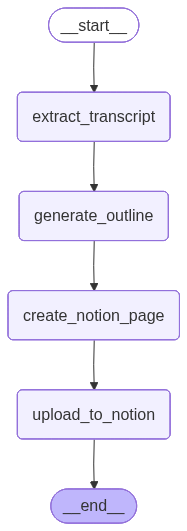

In [14]:
# 워크플로우 그래프 시각화 - 4단계 워크플로우 구조 확인
graph

## 9. 워크플로우 실행

실제 YouTube 영상을 처리하여 전체 워크플로우를 실행합니다.

### 실행 파라미터
- `url`: YouTube 영상 URL
- `database_id`: Notion 데이터베이스 ID
- `title`: 생성될 페이지 제목
- `save_dir`: 다운로드한 영상 파일 저장 경로

### 실행 순서
1. YouTube 영상 다운로드 및 음성 추출
2. OpenAI Whisper를 사용한 텍스트 변환
3. 추출된 텍스트를 바탕으로 마크다운 아웃라인 생성
4. Notion 데이터베이스에 새 페이지 생성
5. ReAct 에이전트와 MCP를 사용하여 구조화된 콘텐츠 업로드


In [15]:
# 워크플로우 실행 - 비동기 방식으로 실행
# YouTube 영상 URL, Notion 데이터베이스 ID, 제목, 저장 경로를 설정하여 전체 프로세스 실행
await graph.ainvoke({
    "url": "https://youtu.be/JYZuZRADCBc?si=oH9UGl-_eLLrzecZ",  # 처리할 YouTube 영상 URL
    "database_id": "2ad02806fca5801e90efe6cf13d24c48",         # Notion 데이터베이스 ID
    "title": "RAG란 무엇인가?",                                    # 페이지 제목
    "save_dir": "./videos"                                      # 다운로드한 영상 파일 저장 경로
})

[youtube] Extracting URL: https://youtu.be/JYZuZRADCBc?si=oH9UGl-_eLLrzecZ
[youtube] JYZuZRADCBc: Downloading webpage
[youtube] JYZuZRADCBc: Downloading tv client config
[youtube] JYZuZRADCBc: Downloading player ef5f17ca-main
[youtube] JYZuZRADCBc: Downloading tv player API JSON
[youtube] JYZuZRADCBc: Downloading ios player API JSON


         player = https://www.youtube.com/s/player/ef5f17ca/player_ias.vflset/en_US/base.js
         n = 6RYn2NSThi8IUqje ; player = https://www.youtube.com/s/player/ef5f17ca/player_ias.vflset/en_US/base.js
         Please report this issue on  https://github.com/yt-dlp/yt-dlp/issues?q= , filling out the appropriate issue template. Confirm you are on the latest version using  yt-dlp -U


[youtube] JYZuZRADCBc: Downloading m3u8 information
[info] Testing format 234
[info] JYZuZRADCBc: Downloading 1 format(s): 234
[hlsnative] Downloading m3u8 manifest
[hlsnative] Total fragments: 80
[download] Destination: ./videos/RAG(Retrieval Augmented Generation)란？│인프런.mp4
[download] 100% of    6.39MiB in 00:00:04 at 1.39MiB/s                   
[ExtractAudio] Destination: ./videos/RAG(Retrieval Augmented Generation)란？│인프런.m4a
Deleting original file ./videos/RAG(Retrieval Augmented Generation)란？│인프런.mp4 (pass -k to keep)
Transcribing part 1!
{'object': 'page', 'id': '2ae02806-fca5-81c7-8bbe-f241234e2df8', 'created_time': '2025-11-17T12:45:00.000Z', 'last_edited_time': '2025-11-17T12:45:00.000Z', 'created_by': {'object': 'user', 'id': 'a3e9d8ff-9759-4e80-a48b-a46689b34764'}, 'last_edited_by': {'object': 'user', 'id': 'a3e9d8ff-9759-4e80-a48b-a46689b34764'}, 'cover': None, 'icon': None, 'parent': {'type': 'database_id', 'database_id': '2ad02806-fca5-801e-90ef-e6cf13d24c48'}, 'archived'

{'url': 'https://youtu.be/JYZuZRADCBc?si=oH9UGl-_eLLrzecZ',
 'transcript': '그러면 이 강의의 핵심인 RAZ, Retrieval Augmented Generation에 대해서 설명해 드리도록 하겠습니다 일단 RAZ는 LLM 어플리케이션에서 굉장히 중요한 개념이에요 그런데 이게 라지 랭규지 모델과 같이 나온 개념은 아니고 훨씬 이전인 자연어처리, 내추럴 랭규지 프로세싱에서 출발된 개념입니다 우리말로 따지면 검색 증강 생성입니다 순서대로 검색 증강 생성인데 이게 어떤 걸 여타내는지 단어를 하나씩 뜯어 보면서 설명해 드리도록 하겠습니다 먼저 Retrieval입니다 Retrieval은 데이터를 가져오는 거예요 데이터를 가져오는 것인데 조금 더 구체적으로 보자면 컴퓨터 시스템에 저장된 자료를 취득하는 것이라는 뜻도 있습니다 저희가 RAZ를 구성할 때 뒤에서 설명해 드릴 벡터 스토어를 활용할 건데 우리가 활용한 벡터 스토어에서 우리가 필요로 하는 데이터를 잘 가져오는 것이라고 보시면 되겠습니다 이거는 구체적으로 말하자면 언어모델이 가지고 있지 않은 정보를 가져오는 거예요 근데 왜 언어모델이 가지고 있지 않은 정보를 가져오냐면 우리는 언어모델이 아웃풋을 만드는데 필요한 정보를 제공해야 되기 때문입니다 언어모델이 답변을 생성하는데 굉장히 능숙하지만 답변 생성을 위한 모든 정보를 가지고 있진 않습니다 최근에 많은 회사들에서 사내 절차 같은 거를 RAZ를 구성을 해가지고 LLM 서비스를 만들고 있습니다 사내 자료는 일반적으로 보안이 걸려 있잖아요 그렇기 때문에 LLM이 학습을 할 때 크롤링을 한다고 해도 보안이 걸려있는 자료를 가지고 있을 수는 없겠죠 그래서 우리가 LLM을 활용한다고 해도 걔네가 답변 생성을 위한 정보를 가지고 있지 않기 때문에 우리가 그 정보를 제공해 주는 거예요 사내 자료가 아니라고 하더라도 GPT-4는 23년 10월까지 학습되어 있습니다 그러니까 24년의 정보는 없는 거예요 예를 들면 24년 카타